# (24) DOVES — LinearGaussian — 1

**Motivation**: Overcomplete, applied to DOVES. Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Import $/$ prep

In [2]:
from _tmp.linvae import prepare_stuff
from _tmp.gapvae import iteration, validate
from _tmp.plotters import plot_latent_space, plot_latent_scatter

In [3]:
n_latents = 512

dim = 16
bias = True

batch_size = 1000
epochs = 3600

lvae, optim, optim_schedule, trn, vld, device, kws_iter = prepare_stuff(
    device_idx=1,
    dim=dim,
    bias=bias,
    poisson=False,
    n_latents=n_latents,
    max_grad_norm=5000, # 500,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
    beta=1.0,
)

+-------------------+------------+
|    Module Name    | Num Params |
+-------------------+------------+
| LinearGaussianVAE |  394.5 K   |
|        ---        |    ---     |
|        enc        |  263.2 K   |
|        dec        |  131.3 K   |
+-------------------+------------+

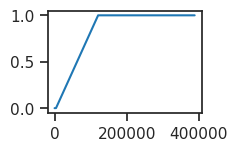

In [7]:
fig, ax = create_figure(1, 1, (2.0, 1.4), layout='constrained')

ax.plot(kws_iter['beta_values'])
plt.show()

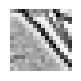

In [8]:
fig, ax = create_figure(1, 1, (1.0, 0.8))
ax.imshow(to_np(vld.dataset.x[1400, 0]), cmap='Greys_r')
remove_ticks(ax)
plt.show()

## Train / Validate

### trn

In [9]:
%%time

pbar = tqdm(range(epochs), ncols=130, position=0)
nelbo, grads = np.zeros(epochs), np.zeros(epochs)

for ep in pbar:
    grad, tot, recon, kl, _ = iteration(
        ep, lvae, trn, optim, optim_schedule, device, **kws_iter)
    nelbo[ep], grads[ep] = recon + 1.0 * kl, grad

    msg = ',  '.join([
        f"grad = {grad:0.1f}",
        f"loss = (kl: {kl:0.1f}, recon: {recon:0.1f}  ——  tot: {tot:0.2f})  ",
    ])
    pbar.set_description(msg)

grad = 16.1,  loss = (kl: 52.8, recon: 101.8  ——  tot: 154.55)  : 100%|███████████████████████| 3600/3600 [32:13<00:00,  1.86it/s]

CPU times: user 6h 46min 14s, sys: 7min 20s, total: 6h 53min 34s
Wall time: 32min 13s


In [10]:
loss_vld = validate(lvae, vld, device)
loss_vld

{'kl': 49.89573829568196,
 'recon': 106.3860135419874,
 'tot': 156.28175170297104}

## Plot weights

In [49]:
w_dec = lvae.dec.weight.T.reshape(
    n_latents, 1, dim, dim)
grid_dec = make_grid(w_dec, (16, 32))

w_dec.shape, grid_dec.shape

(torch.Size([512, 1, 16, 16]), (271, 543))

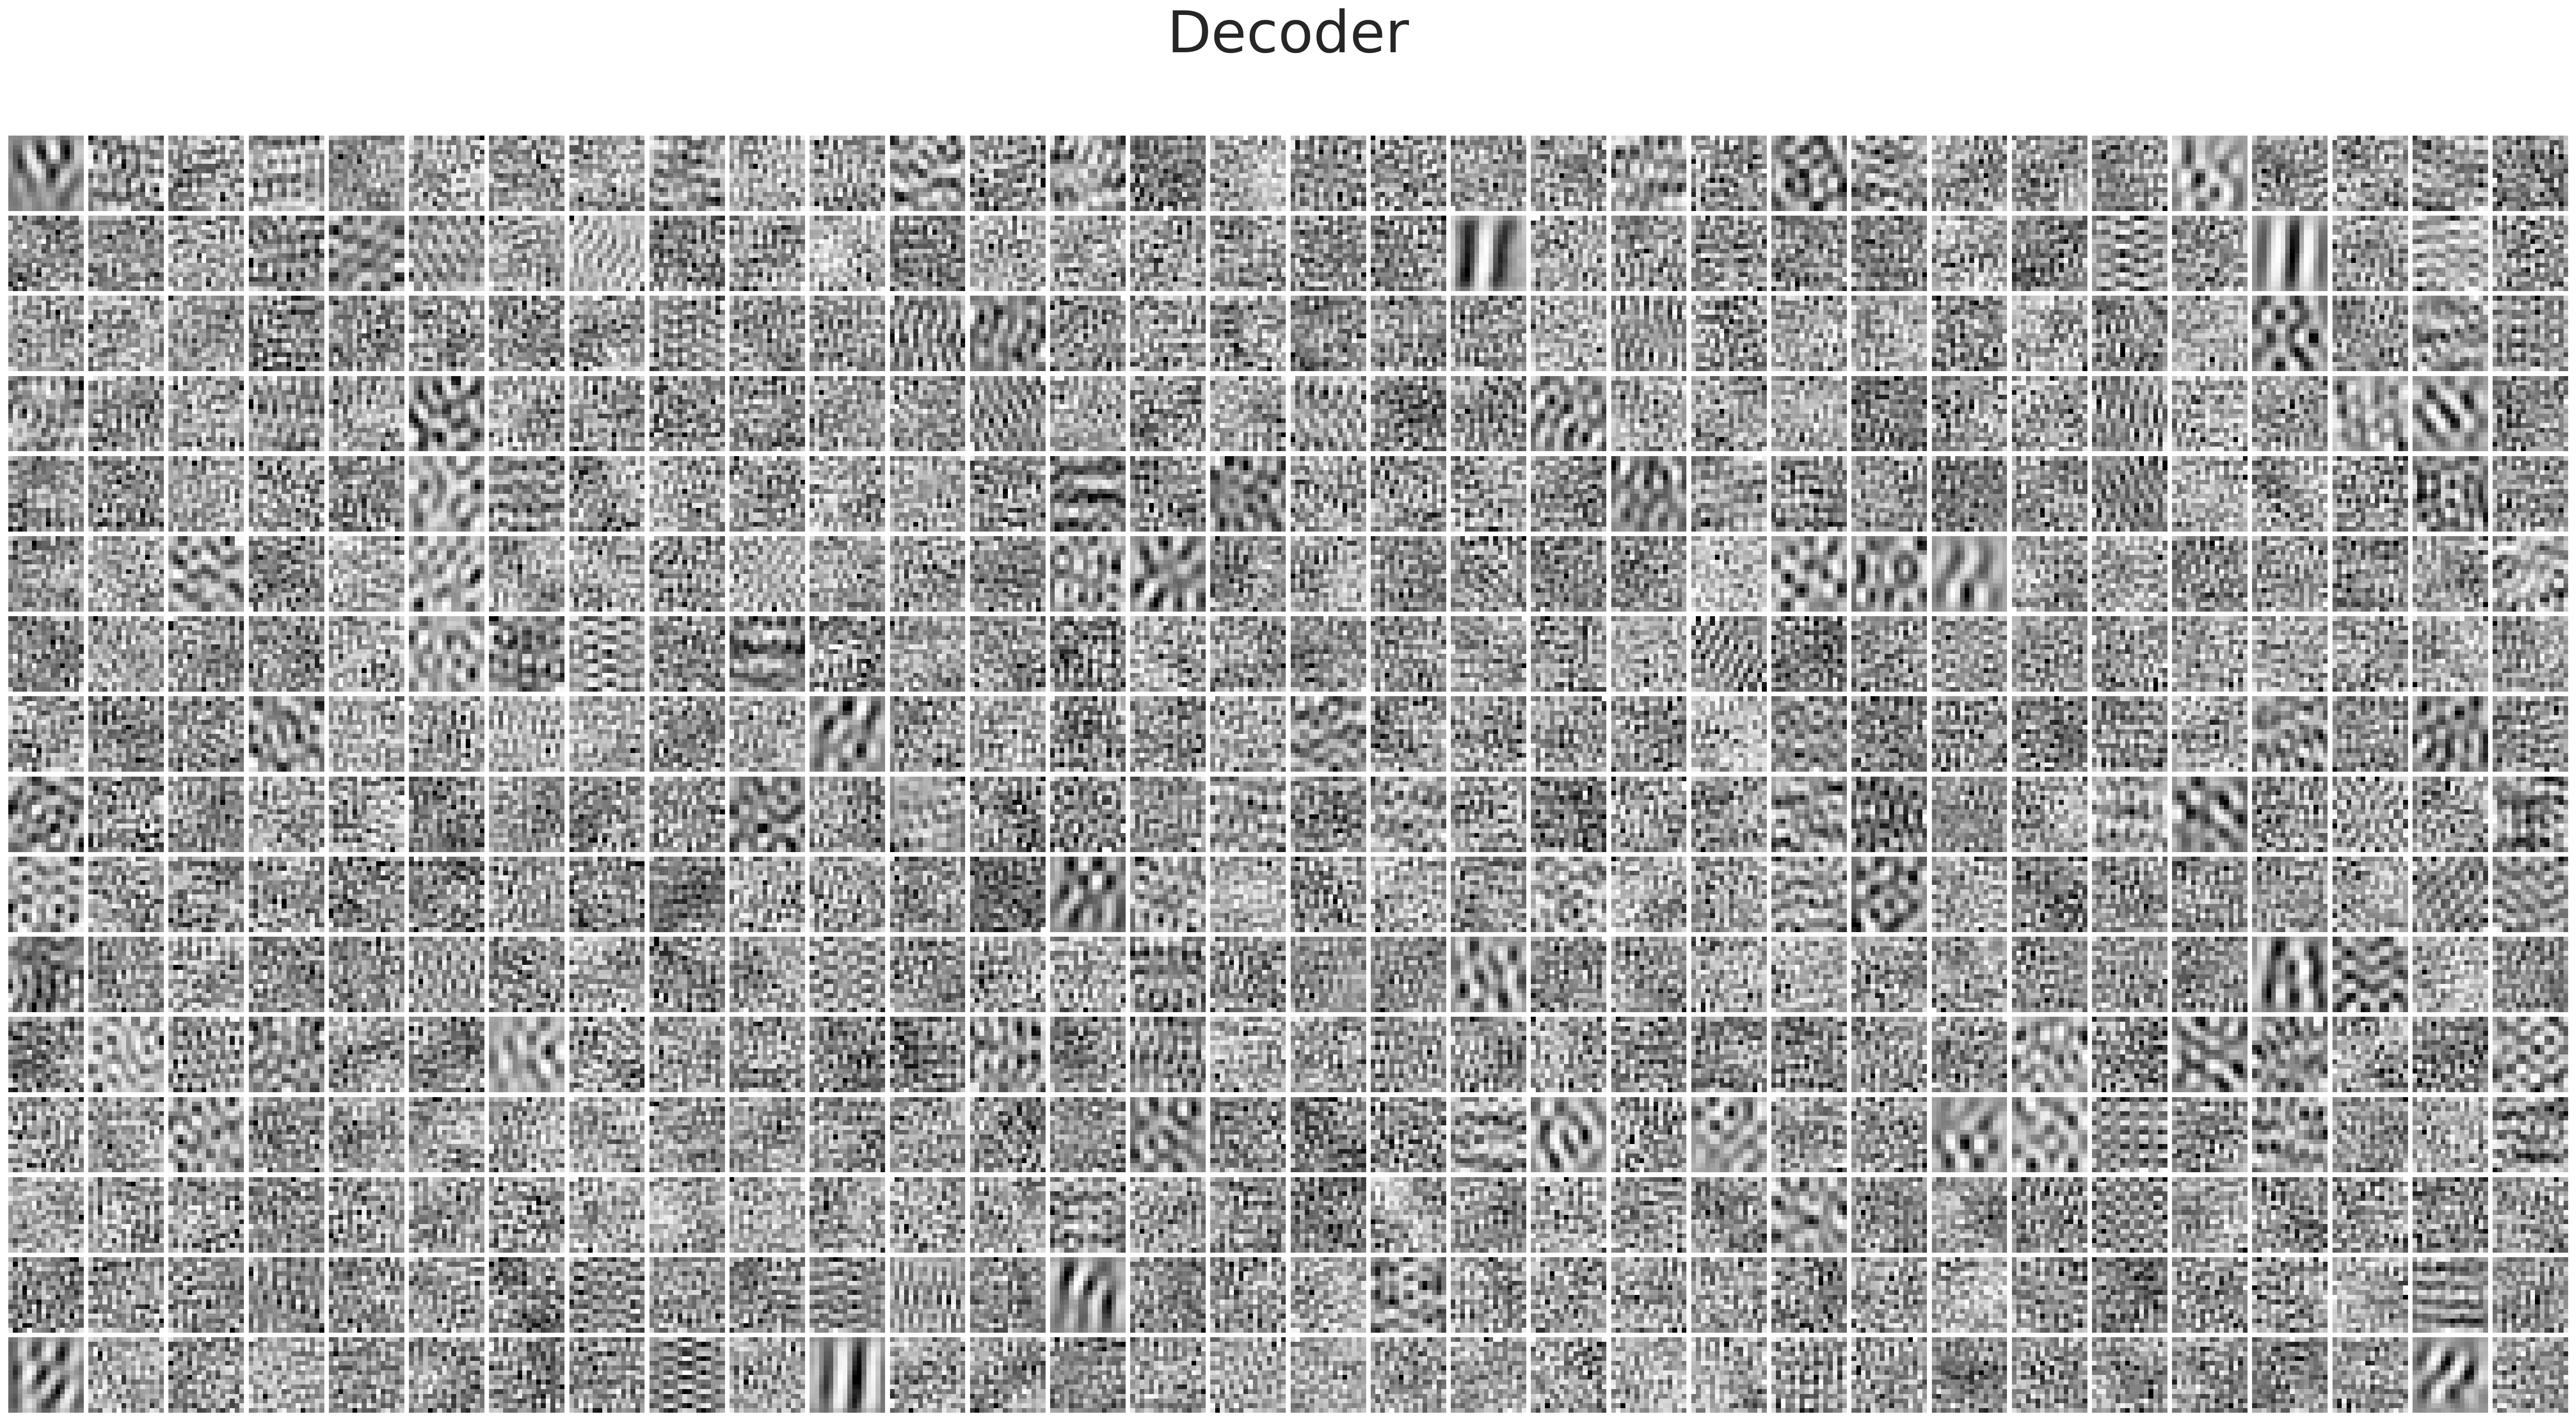

In [50]:
fig, ax = create_figure(1, 1, (50, 20), dpi=200)
ax.imshow(grid_dec, cmap='Greys_r')
ax.set_title('Decoder', fontsize=50, y=1.06)
remove_ticks(ax)
plt.show()

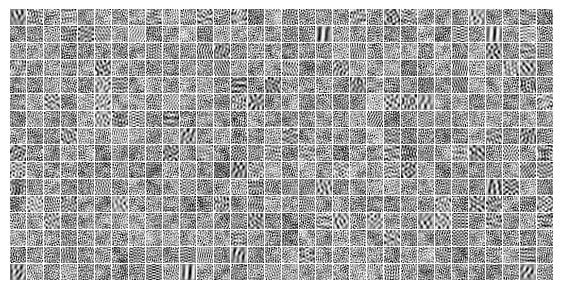

In [51]:
fig, ax = create_figure(1, 1, (7, 5.5), dpi=100)
ax.imshow(grid_dec, cmap='Greys_r')
remove_ticks(ax)
plt.show()

## Data PCA

In [38]:
svd = torch.svd(trn.dataset.x.squeeze().flatten(start_dim=1))
pcs = to_np(svd.V.mH).reshape(-1, dim, dim)
ss = 100 * to_np(svd.S / svd.S.sum())

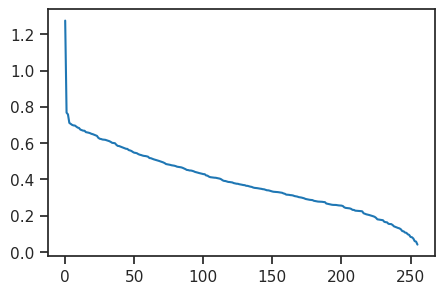

In [61]:
plt.plot(ss);

In [54]:
grid_pcs = make_grid(pcs, (16, 16))

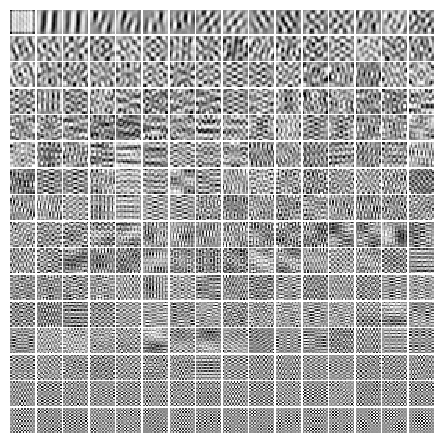

In [57]:
fig, ax = create_figure(1, 1, (5.5, 5.5), dpi=100)
ax.imshow(grid_pcs, cmap='Greys_r')
remove_ticks(ax)
plt.show()